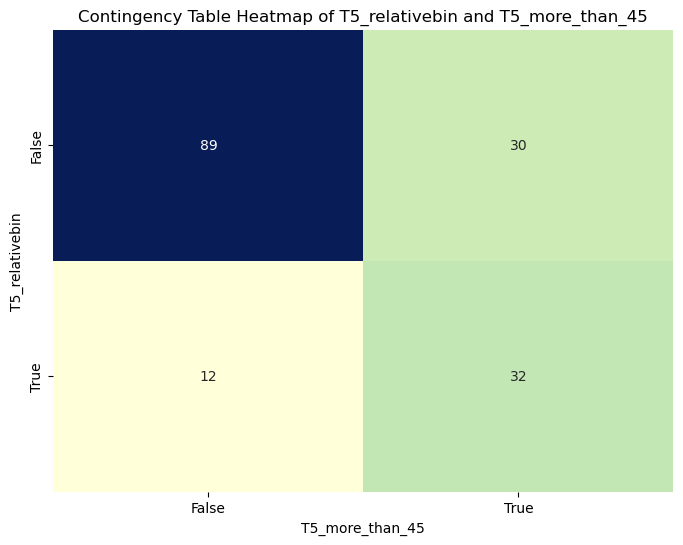

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 Model Dataset  Accuracy  Precision    Recall        F1
0  Logistic Regression    Test   0.40625   0.607692  0.733333  0.662857
1        Decision Tree    Test   0.50000   0.697917  0.708333  0.691799
2              XGBoost    Test   0.43750   0.541667  0.800000  0.644689
3           Null Model    Test   0.25000   0.234375  0.500000  0.319149


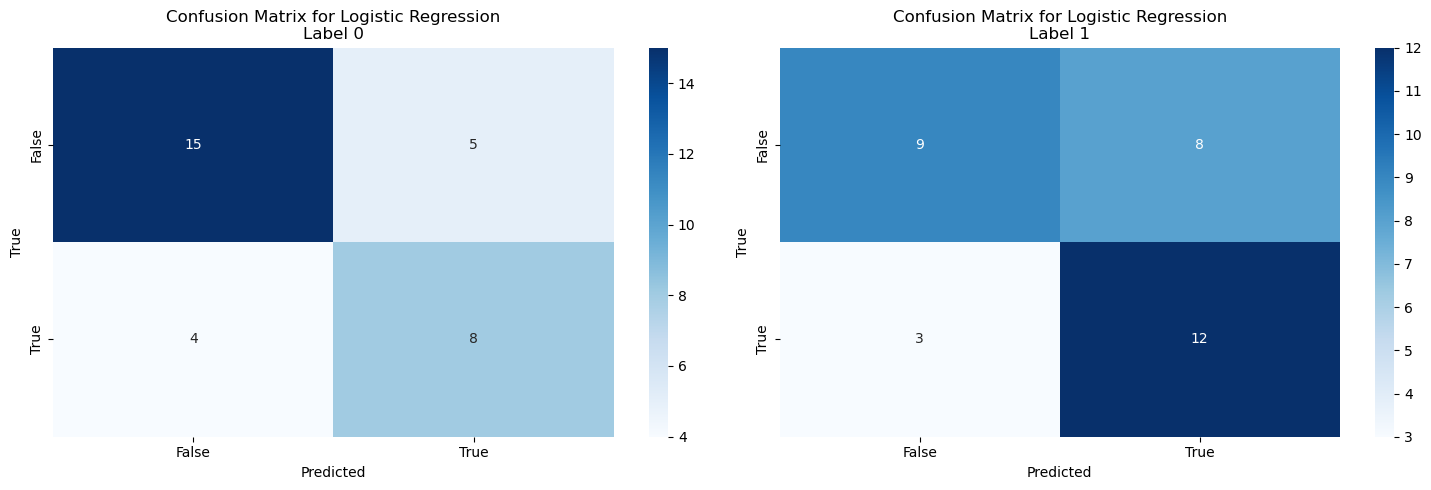

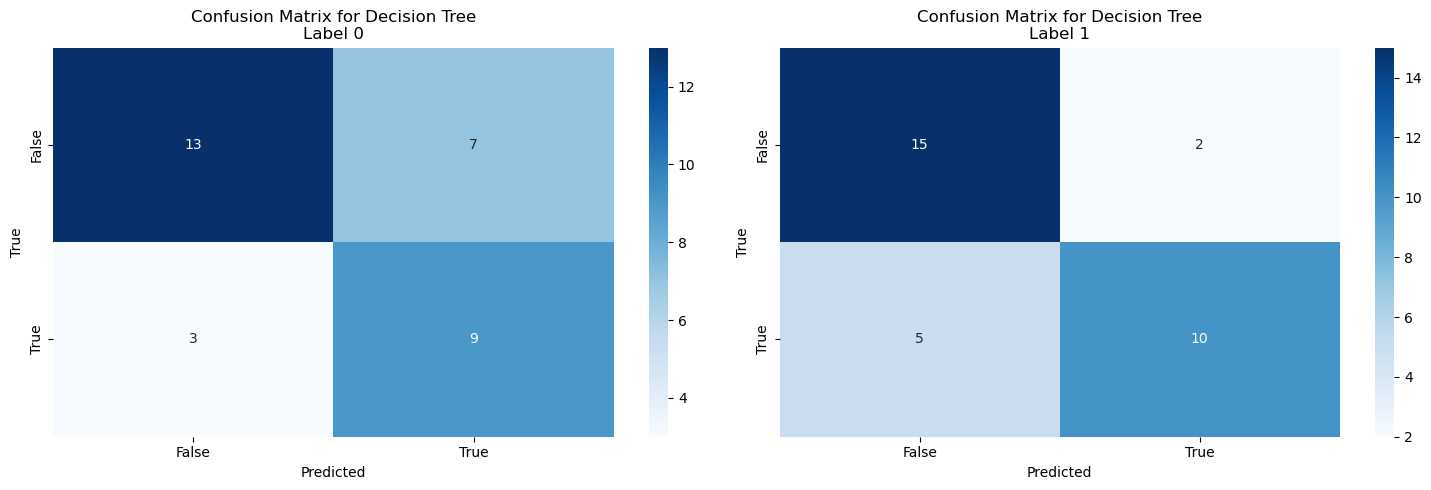

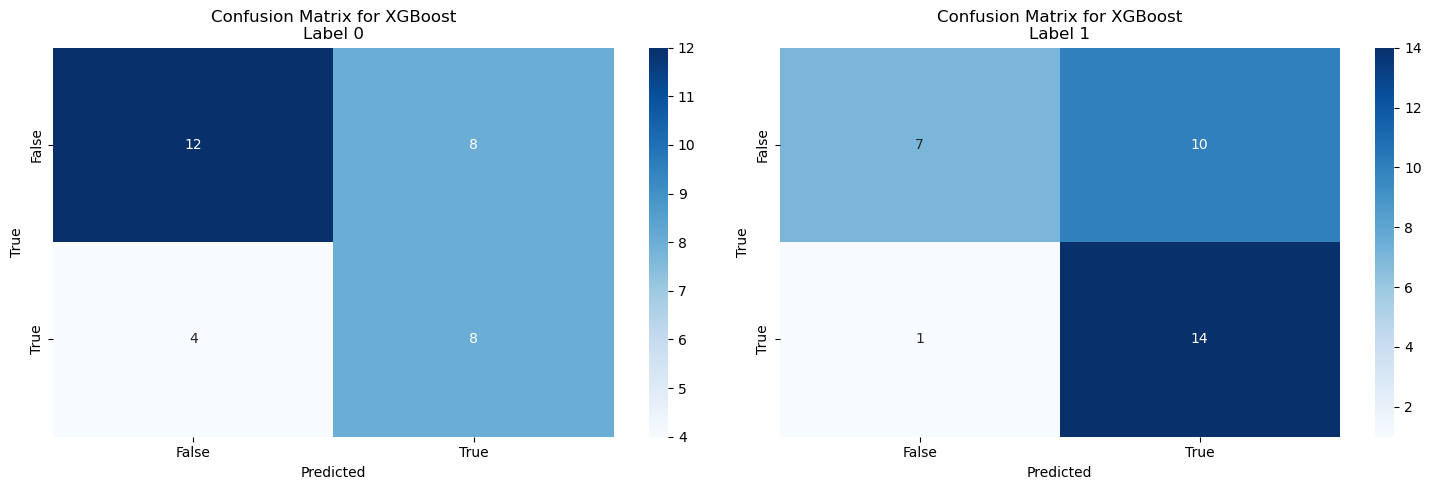

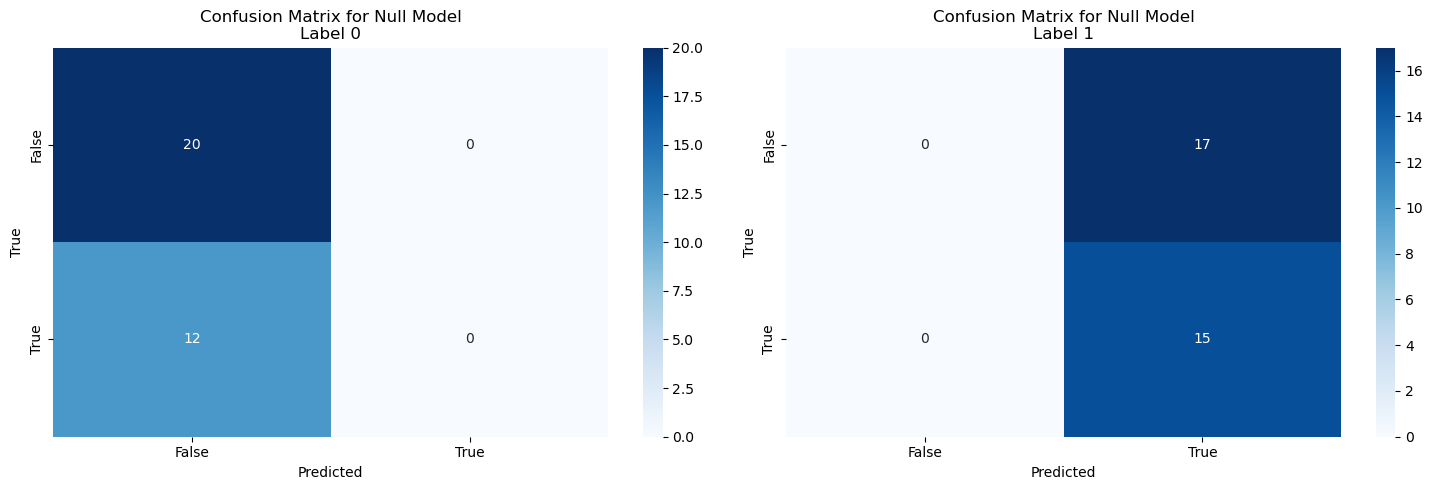

In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the voorspelers file with semicolon separator
voorspellers_df = pd.read_csv('../Export/Voorspellers.csv', delimiter=';')

# Load the uitkomstmaat data_clean_cleanset
uitkomstmaat_df = pd.read_csv('../Export/uitkomstmaat.csv', delimiter=';')
uitkomstmaat_vars = uitkomstmaat_df[["patientnummer", "T0", "T5"]]

ML_df = pd.merge(voorspellers_df, uitkomstmaat_vars, left_on='Participant Id', right_on='patientnummer', how='inner')
ML_df.drop(columns=['Participant Id', 'patientnummer'], inplace=True)
ML_df['T5_relative'] = ML_df['T5'] / ML_df['T0']
ML_df['T5_relativebin'] = ML_df['T5_relative'] >= 1

ML_df['T5_more_than_45'] = ML_df['T5'] > 45
ML_df['T5_recovered'] = (ML_df['T5_relativebin']) & (ML_df['T5_more_than_45'])

# Create a contingency table
contingency_table = pd.crosstab(ML_df['T5_relativebin'], ML_df['T5_more_than_45'])

# Plot the contingency table as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Contingency Table Heatmap of T5_relativebin and T5_more_than_45')
plt.xlabel('T5_more_than_45')
plt.ylabel('T5_relativebin')
plt.show()

# Assuming data_clean is already defined and clean
data_clean = ML_df.copy()

# Identify columns
continuous_columns = [
    'T0_age', 'T0_BMI', 'T0_BIA_VVM_kg', 'T0_BIA_vetmassa_kg', 
    'Time_pretreat_OK', 'OK_Duration_min', 'Length_of_stay', 
    'T0_30SCST', 'T0_fatigue', 'T0_protein_perc', 'T0_kcal_perc', 
    'T0_CT_SMI', 'T0_CT_SMRA', 't0_gses_totaal_score', 
    'T0_participation_ability', 'T0_participation_satisfaction', 
    't0_EQ_5D_5L_beschrijvend-systeem_score', 'T0_pain', 'T0'
]

categorical_columns = [
    'T0_VVMI_per', 'Education', 'household', 'T0_Tumorsize', 
    'T0_diseaseburden_cat', 'T0_selfcare', 'T0_Locusofcontrol_cat',
    'T0_socialsupport_cat', 'T0_coping_cat', 'AMEXO_8_day1', 
    'AMEXO_9_day2', 'AMEXO_10_day3', 'T0_sondevoeding', 'T0_protein_cat',
    'T0_kcal_cat', 'T0_ASM_low', 'T0_anxiety_cat', 'T0_depression_cat'
]

# Remove rows with missing values in T5
if 'T5_relative' in data_clean.columns:
    data_clean = data_clean.dropna(subset=['T5_relative'])

# Remove rows where T5 > 80
if 'T5' in data_clean.columns:
    data_clean = data_clean[data_clean['T5'] <= 80]

# Initialize the SimpleImputer with median strategy for continuous variables
median_imputer = SimpleImputer(strategy='median')

# Apply median imputation excluding 'T5'
existing_continuous_columns = [col for col in continuous_columns if col in data_clean.columns]
if existing_continuous_columns:
    data_clean[existing_continuous_columns] = median_imputer.fit_transform(data_clean[existing_continuous_columns])

# Initialize the SimpleImputer with mode strategy for categorical variables
mode_imputer = SimpleImputer(strategy='most_frequent')

# Apply mode imputation to categorical columns
existing_categorical_columns = [col for col in categorical_columns if col in data_clean.columns]
if existing_categorical_columns:
    data_clean[existing_categorical_columns] = mode_imputer.fit_transform(data_clean[existing_categorical_columns])

# Fill missing values for specific columns with 0
for col in ['Complications_CCI', 'readmission_30days', 'Time_OK_posttreat']:
    if col in data_clean.columns:
        data_clean[col] = data_clean[col].fillna(0)

# Verify no remaining missing values except for T5
missing_values_final_check = data_clean.isnull().sum()
print(missing_values_final_check.sum())

# Select the features and target variables
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_recovered', 'T5_more_than_45', 'T5_relativebin'])
y = data_clean[['T5_relativebin', 'T5_more_than_45']]

# Maak een train/test split met 70% train en 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Functie om de metrics te berekenen
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, mcm

# Initialize and train models
# Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)

# Decision Tree with max_leaf_nodes to reduce overfitting
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
tree_model.fit(X_train, y_train)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode().iloc[0]
    def predict(self, X):
        return np.tile(self.mode, (len(X), 1))

null_model = NullModel()
null_model.fit(X_train, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

def evaluate_model(model, model_name, X_test, y_test):
    y_test_pred = model.predict(X_test)
    accuracy, precision, recall, f1, mcm = calculate_metrics(y_test, y_test_pred)
    metrics['Model'].append(model_name)
    metrics['Dataset'].append('Test')
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1'].append(f1)
    return mcm

# Logistic Regression
mcm_log_reg = evaluate_model(log_reg, 'Logistic Regression', X_test, y_test)

# Decision Tree
mcm_tree = evaluate_model(tree_model, 'Decision Tree', X_test, y_test)

# XGBoost
mcm_xgb = evaluate_model(xgb_model, 'XGBoost', X_test, y_test)

# Null Model
mcm_null = evaluate_model(null_model, 'Null Model', X_test, y_test)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the confusion matrices
def plot_confusion_matrices(mcm, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes = axes.ravel()
    for i, (ax, matrix) in enumerate(zip(axes, mcm)):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix for {model_name}\nLabel {i}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_xticklabels(['False', 'True'])
        ax.set_yticklabels(['False', 'True'])
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(mcm_log_reg, 'Logistic Regression')
plot_confusion_matrices(mcm_tree, 'Decision Tree')
plot_confusion_matrices(mcm_xgb, 'XGBoost')
plot_confusion_matrices(mcm_null, 'Null Model')


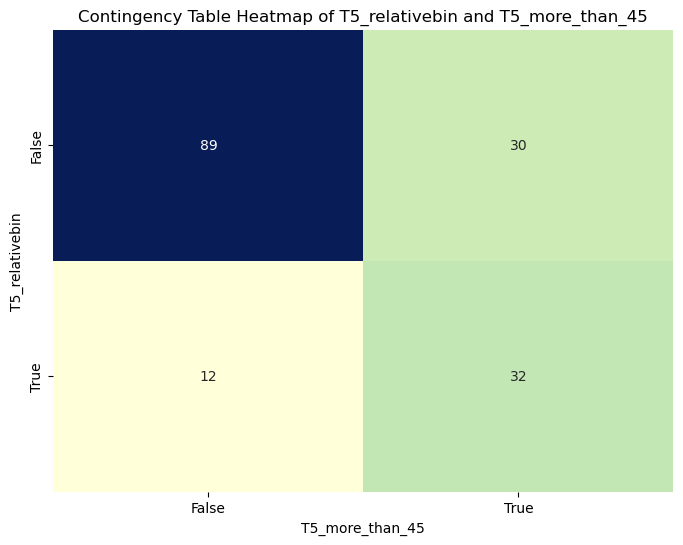

c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 Model Dataset  Accuracy  Precision    Recall        F1
0  Logistic Regression    Test   0.40625   0.607692  0.733333  0.662857
1        Decision Tree    Test   0.43750   0.551084  0.733333  0.628803
2              XGBoost    Test   0.53125   0.585294  0.800000  0.675862
3           Null Model    Test   0.25000   0.234375  0.500000  0.319149


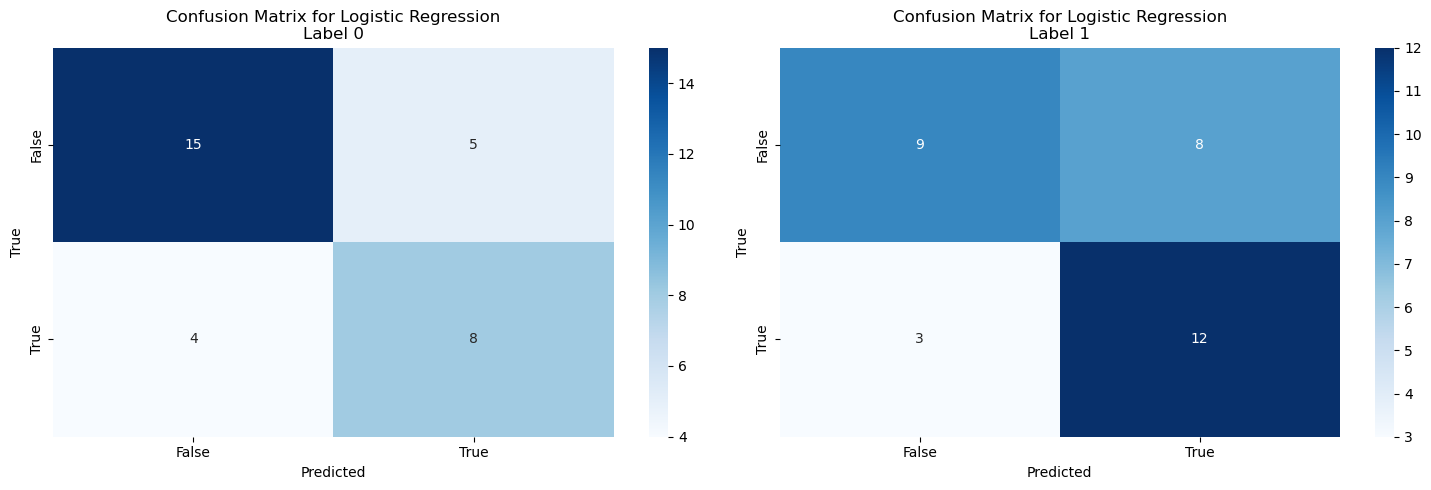

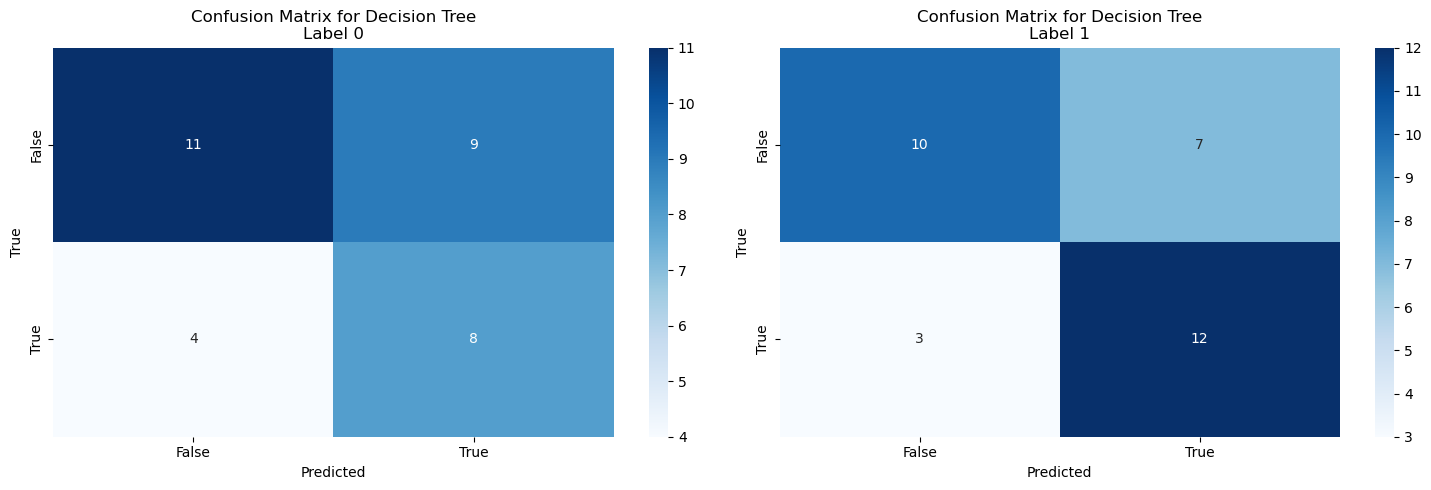

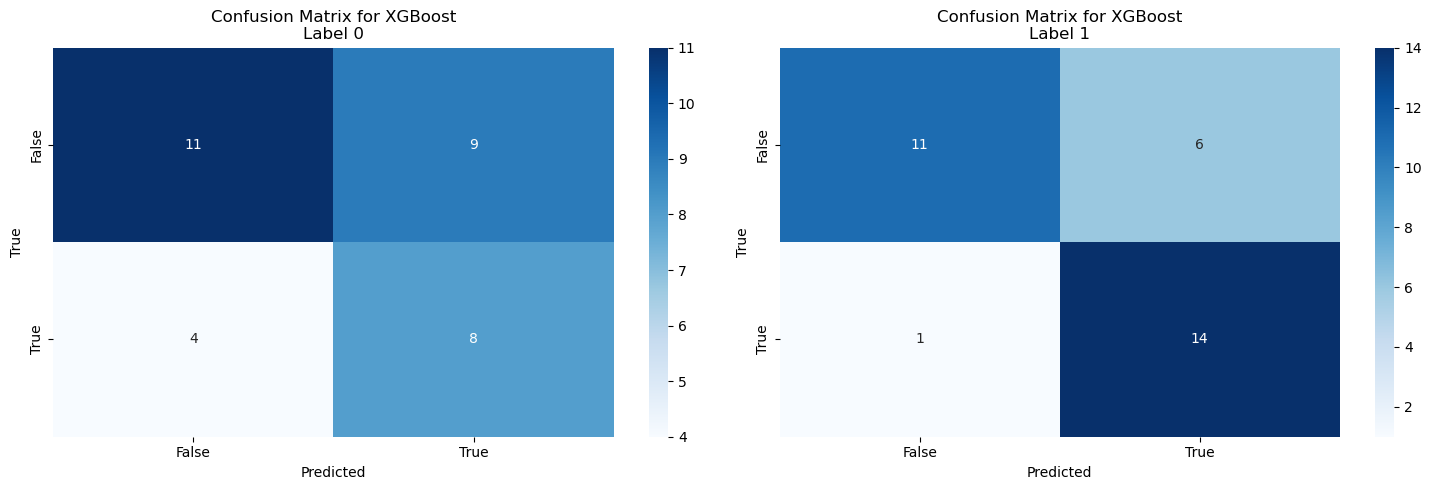

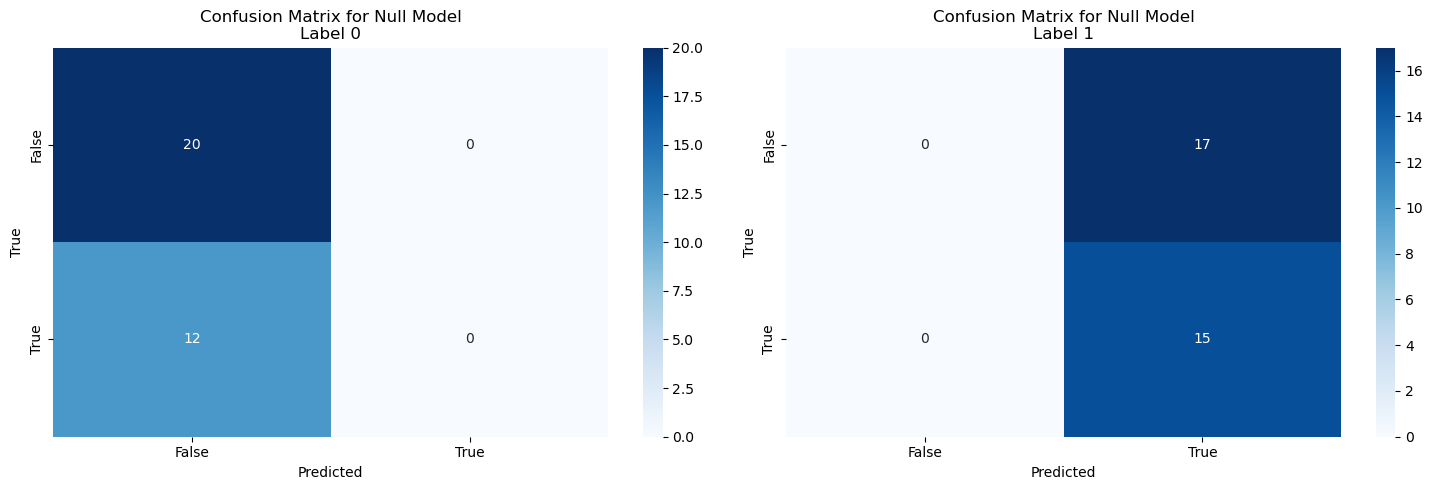

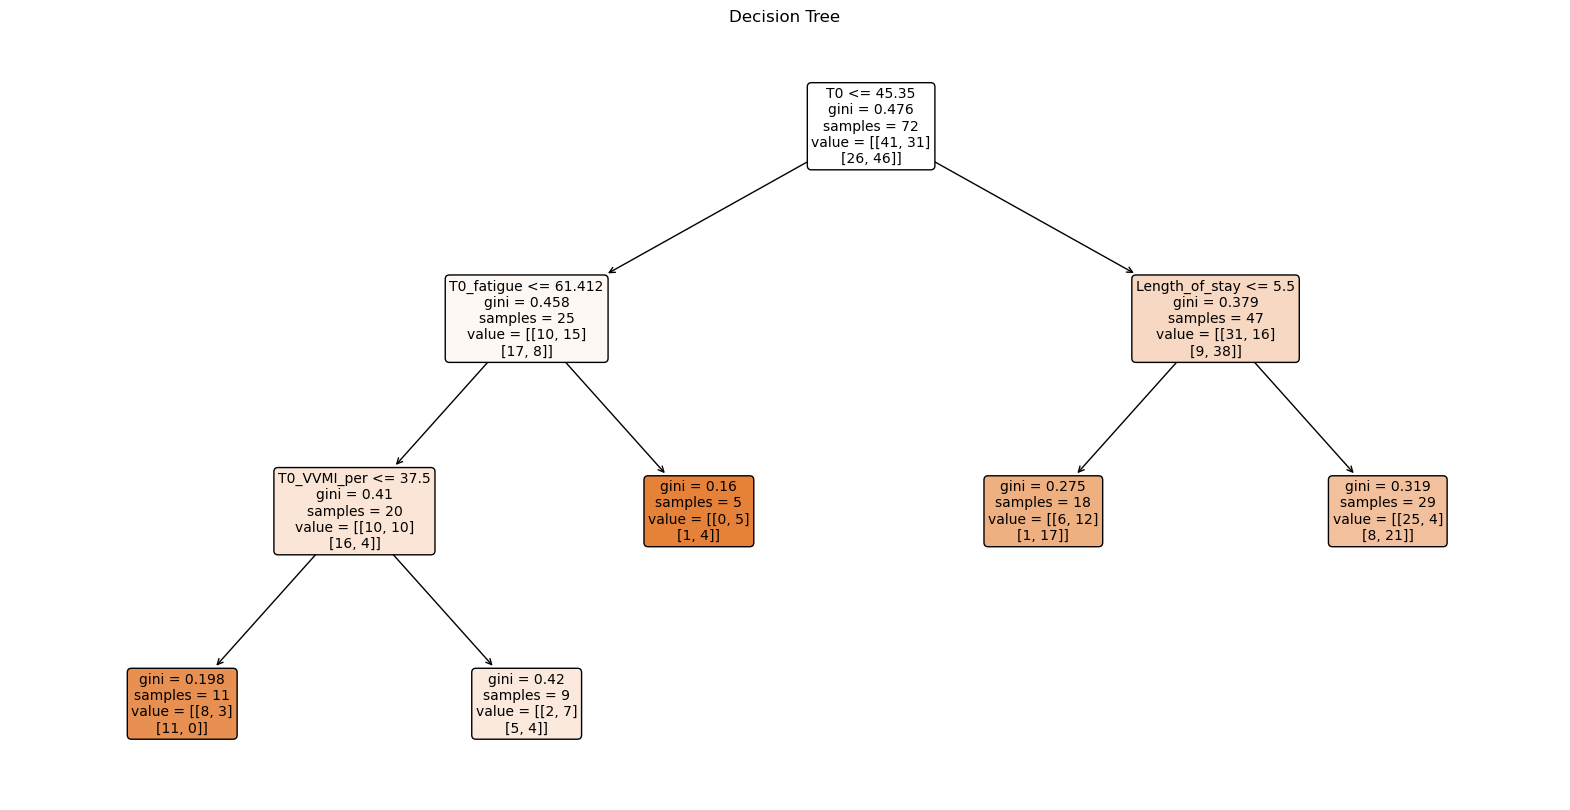

In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the voorspelers file with semicolon separator
voorspellers_df = pd.read_csv('../Export/Voorspellers.csv', delimiter=';')

# Load the uitkomstmaat data_clean_cleanset
uitkomstmaat_df = pd.read_csv('../Export/uitkomstmaat.csv', delimiter=';')
uitkomstmaat_vars = uitkomstmaat_df[["patientnummer", "T0", "T5"]]

ML_df = pd.merge(voorspellers_df, uitkomstmaat_vars, left_on='Participant Id', right_on='patientnummer', how='inner')
ML_df.drop(columns=['Participant Id', 'patientnummer'], inplace=True)
ML_df['T5_relative'] = ML_df['T5'] / ML_df['T0']
ML_df['T5_relativebin'] = ML_df['T5_relative'] >= 1

ML_df['T5_more_than_45'] = ML_df['T5'] > 45
ML_df['T5_recovered'] = (ML_df['T5_relativebin']) & (ML_df['T5_more_than_45'])

# Create a contingency table
contingency_table = pd.crosstab(ML_df['T5_relativebin'], ML_df['T5_more_than_45'])

# Plot the contingency table as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Contingency Table Heatmap of T5_relativebin and T5_more_than_45')
plt.xlabel('T5_more_than_45')
plt.ylabel('T5_relativebin')
plt.show()

# Assuming data_clean is already defined and clean
data_clean = ML_df.copy()

# Identify columns
continuous_columns = [
    'T0_age', 'T0_BMI', 'T0_BIA_VVM_kg', 'T0_BIA_vetmassa_kg', 
    'Time_pretreat_OK', 'OK_Duration_min', 'Length_of_stay', 
    'T0_30SCST', 'T0_fatigue', 'T0_protein_perc', 'T0_kcal_perc', 
    'T0_CT_SMI', 'T0_CT_SMRA', 't0_gses_totaal_score', 
    'T0_participation_ability', 'T0_participation_satisfaction', 
    't0_EQ_5D_5L_beschrijvend-systeem_score', 'T0_pain', 'T0'
]

categorical_columns = [
    'T0_VVMI_per', 'Education', 'household', 'T0_Tumorsize', 
    'T0_diseaseburden_cat', 'T0_selfcare', 'T0_Locusofcontrol_cat',
    'T0_socialsupport_cat', 'T0_coping_cat', 'AMEXO_8_day1', 
    'AMEXO_9_day2', 'AMEXO_10_day3', 'T0_sondevoeding', 'T0_protein_cat',
    'T0_kcal_cat', 'T0_ASM_low', 'T0_anxiety_cat', 'T0_depression_cat'
]

# Remove rows with missing values in T5
if 'T5_relative' in data_clean.columns:
    data_clean = data_clean.dropna(subset=['T5_relative'])

# Remove rows where T5 > 80
if 'T5' in data_clean.columns:
    data_clean = data_clean[data_clean['T5'] <= 80]

# Initialize the SimpleImputer with median strategy for continuous variables
median_imputer = SimpleImputer(strategy='median')

# Apply median imputation excluding 'T5'
existing_continuous_columns = [col for col in continuous_columns if col in data_clean.columns]
if existing_continuous_columns:
    data_clean[existing_continuous_columns] = median_imputer.fit_transform(data_clean[existing_continuous_columns])

# Initialize the SimpleImputer with mode strategy for categorical variables
mode_imputer = SimpleImputer(strategy='most_frequent')

# Apply mode imputation to categorical columns
existing_categorical_columns = [col for col in categorical_columns if col in data_clean.columns]
if existing_categorical_columns:
    data_clean[existing_categorical_columns] = mode_imputer.fit_transform(data_clean[existing_categorical_columns])

# Fill missing values for specific columns with 0
for col in ['Complications_CCI', 'readmission_30days', 'Time_OK_posttreat']:
    if col in data_clean.columns:
        data_clean[col] = data_clean[col].fillna(0)

# Verify no remaining missing values except for T5
missing_values_final_check = data_clean.isnull().sum()
print(missing_values_final_check.sum())

# Select the features and target variables
X = data_clean.drop(columns=['T5', 'T5_relative', 'T5_recovered', 'T5_more_than_45', 'T5_relativebin'])
y = data_clean[['T5_relativebin', 'T5_more_than_45']]

# Train/test split with 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train models
# Logistic Regression (multi-label using OneVsRestClassifier)
log_reg = OneVsRestClassifier(LogisticRegression(max_iter=10000))
log_reg.fit(X_train, y_train)

# Decision Tree with max_leaf_nodes to reduce overfitting
tree_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5)
tree_model.fit(X_train, y_train)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mode = y.mode().iloc[0]
    def predict(self, X):
        return np.tile(self.mode, (len(X), 1))

null_model = NullModel()
null_model.fit(X_train, y_train)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, mcm

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

def evaluate_model(model, model_name, X_test, y_test):
    y_test_pred = model.predict(X_test)
    accuracy, precision, recall, f1, mcm = calculate_metrics(y_test, y_test_pred)
    metrics['Model'].append(model_name)
    metrics['Dataset'].append('Test')
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1'].append(f1)
    return mcm

# Logistic Regression
mcm_log_reg = evaluate_model(log_reg, 'Logistic Regression', X_test, y_test)

# Decision Tree
mcm_tree = evaluate_model(tree_model, 'Decision Tree', X_test, y_test)

# XGBoost
mcm_xgb = evaluate_model(xgb_model, 'XGBoost', X_test, y_test)

# Null Model
mcm_null = evaluate_model(null_model, 'Null Model', X_test, y_test)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)

# Plot the confusion matrices
def plot_confusion_matrices(mcm, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes = axes.ravel()
    for i, (ax, matrix) in enumerate(zip(axes, mcm)):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix for {model_name}\nLabel {i}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_xticklabels(['False', 'True'])
        ax.set_yticklabels(['False', 'True'])
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(mcm_log_reg, 'Logistic Regression')
plot_confusion_matrices(mcm_tree, 'Decision Tree')
plot_confusion_matrices(mcm_xgb, 'XGBoost')
plot_confusion_matrices(mcm_null, 'Null Model')

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, 
          feature_names=X.columns, 
          class_names=['False', 'True'], 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title('Decision Tree')
plt.show()
